In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
import json
sys.path.append('../src/')

In [2]:
import importlib 
import linear_var_hypernet as linear_var_hypernet
import var_net as var_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(linear_var_hypernet)



<module 'linear_var_hypernet' from '/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 200 #количество эпох
lamb = [10**2, 10**3, 10**4, 10**5, 10**6]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_wine'

lambda_encode = lambda x: (t.log(x) - np.log(100.0))/(np.log(10**6) - np.log(100.0))
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)
lambda_encode(lamb[0]), lambda_encode(lamb[-1])

(tensor(0.), tensor(1.))

In [5]:
from sklearn.datasets import load_wine
from torch.utils.data import TensorDataset, DataLoader
wine_X , wine_Y = load_wine(return_X_y=True)

rs = np.random.RandomState(42)
ids = list(range(len(wine_X)))
rs.shuffle(ids)

train_X, test_X = wine_X[ids[:len(ids)*4//5]], wine_X[ids[len(ids)*4//5:]]
train_Y, test_Y = wine_Y[ids[:len(ids)*4//5]], wine_Y[ids[len(ids)*4//5:]]

mean = np.mean(train_X, 0)
std = np.std(train_X, 0)

train_X = (train_X - mean)/std
test_X = (test_X - mean)/std




train_X = t.tensor(train_X).to(device)
test_X = t.tensor(test_X).to(device)
train_Y = t.tensor(train_Y).to(device)
test_Y = t.tensor(test_Y).to(device)


train_data = TensorDataset(train_X.float(),train_Y)
train_loader = DataLoader(train_data) 

test_data = TensorDataset(test_X.float(),test_Y)
test_loader = DataLoader(test_data) 

        

In [8]:
t.manual_seed(0)
lambda_sample_num = 5
for start in range(start_num):                    
        net = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(13, 3,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = 'epoch {}: '.format(e)                
            utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                  lambda_encode, net, device, loss_fn, optim, label, rep=True ,  p_gen=lambda p_:p_*4+2)
            if e%5 == 0:
                print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
        t.save(net.state_dict(), os.path.join(path_to_save, 'rep_linear_start_{}.cpk'.format(start)))

/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:162: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:164: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)
epoch 0: [1522.2747 2263.4675]: 100%|██████████| 142/142 [00:03<00:00, 43.27it/s]


{tensor(100): 0.6666666666666666, tensor(1000): 0.5555555555555556, tensor(10000): 0.3611111111111111, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3611111111111111}


epoch 5: [479.96686 719.1331 ]: 100%|██████████| 142/142 [00:03<00:00, 43.39it/s]


{tensor(100): 0.6388888888888888, tensor(1000): 0.5555555555555556, tensor(10000): 0.5833333333333334, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 10: [252.66866 383.02103]: 100%|██████████| 142/142 [00:03<00:00, 43.22it/s]


{tensor(100): 0.5277777777777778, tensor(1000): 0.5, tensor(10000): 0.5, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 15: [107.18059 165.54315]: 100%|██████████| 142/142 [00:03<00:00, 43.36it/s]  


{tensor(100): 0.3333333333333333, tensor(1000): 0.3611111111111111, tensor(10000): 0.4444444444444444, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 20: [45.880844 69.64652 ]: 100%|██████████| 142/142 [00:03<00:00, 45.14it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 25: [20.134754 30.12339 ]: 100%|██████████| 142/142 [00:03<00:00, 44.58it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 30: [16.238298 23.653507]: 100%|██████████| 142/142 [00:03<00:00, 46.31it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 35: [12.847741 18.973572]: 100%|██████████| 142/142 [00:03<00:00, 46.21it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 40: [ 8.5318775 12.479323 ]: 100%|██████████| 142/142 [00:03<00:00, 45.65it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 45: [6.5665913 9.718559 ]: 100%|██████████| 142/142 [00:03<00:00, 43.12it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3333333333333333}


epoch 50: [5.59354   7.8070097]: 100%|██████████| 142/142 [00:03<00:00, 43.06it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.08333333333333333}


epoch 55: [4.2244935 6.0268726]: 100%|██████████| 142/142 [00:03<00:00, 43.07it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.027777777777777776}


epoch 60: [2.4733531 3.4091437]: 100%|██████████| 142/142 [00:03<00:00, 43.11it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.08333333333333333}


epoch 65: [1.6535369 2.182186 ]: 100%|██████████| 142/142 [00:03<00:00, 43.44it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.4444444444444444, tensor(1000000): 0.05555555555555555}


epoch 70: [1.1346855 1.3793923]: 100%|██████████| 142/142 [00:03<00:00, 42.94it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.3333333333333333, tensor(10000): 0.3333333333333333, tensor(100000): 0.5277777777777778, tensor(1000000): 0.027777777777777776}


epoch 75: [0.8018291  0.88285327]: 100%|██████████| 142/142 [00:03<00:00, 43.99it/s]


{tensor(100): 0.7222222222222222, tensor(1000): 0.7222222222222222, tensor(10000): 0.7777777777777778, tensor(100000): 0.8333333333333334, tensor(1000000): 0.08333333333333333}


epoch 80: [0.7445352  0.79580474]: 100%|██████████| 142/142 [00:03<00:00, 43.57it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 85: [0.72414637 0.7658008 ]: 100%|██████████| 142/142 [00:03<00:00, 43.64it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 90: [0.70831066 0.7417235 ]: 100%|██████████| 142/142 [00:03<00:00, 43.38it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 95: [0.69628686 0.72328335]: 100%|██████████| 142/142 [00:03<00:00, 43.21it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 100: [0.67965215 0.69870025]: 100%|██████████| 142/142 [00:03<00:00, 43.38it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 105: [0.6700663 0.6862725]: 100%|██████████| 142/142 [00:03<00:00, 43.29it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 110: [0.6658287 0.6776582]: 100%|██████████| 142/142 [00:03<00:00, 42.55it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 115: [0.65880555 0.66896087]: 100%|██████████| 142/142 [00:03<00:00, 43.17it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 120: [0.6567491 0.6639219]: 100%|██████████| 142/142 [00:03<00:00, 42.79it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 125: [0.65085125 0.65771955]: 100%|██████████| 142/142 [00:03<00:00, 42.85it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 130: [0.65366924 0.659149  ]: 100%|██████████| 142/142 [00:03<00:00, 43.31it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 135: [0.6520951  0.65746087]: 100%|██████████| 142/142 [00:03<00:00, 43.63it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 140: [0.6524602  0.65732217]: 100%|██████████| 142/142 [00:03<00:00, 43.05it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.027777777777777776}


epoch 145: [0.6501914 0.6549409]: 100%|██████████| 142/142 [00:03<00:00, 43.15it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 150: [0.65226746 0.6564631 ]: 100%|██████████| 142/142 [00:03<00:00, 43.65it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 155: [0.6492717 0.6533657]: 100%|██████████| 142/142 [00:03<00:00, 42.95it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 160: [0.6499193  0.65419674]: 100%|██████████| 142/142 [00:03<00:00, 44.11it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 165: [0.64851195 0.65259075]: 100%|██████████| 142/142 [00:03<00:00, 42.80it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 170: [0.648981  0.6531332]: 100%|██████████| 142/142 [00:03<00:00, 44.07it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 175: [0.6483513  0.65230685]: 100%|██████████| 142/142 [00:03<00:00, 43.45it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 180: [0.6525417  0.65670574]: 100%|██████████| 142/142 [00:03<00:00, 43.44it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 185: [0.648819   0.65255904]: 100%|██████████| 142/142 [00:03<00:00, 43.80it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 190: [0.6486186 0.6525652]: 100%|██████████| 142/142 [00:03<00:00, 42.72it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 195: [0.6519405 0.6557773]: 100%|██████████| 142/142 [00:03<00:00, 43.59it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.1388888888888889}


epoch 0: [1880.0557 2832.017 ]: 100%|██████████| 142/142 [00:03<00:00, 43.25it/s] 


{tensor(100): 0.3888888888888889, tensor(1000): 0.5555555555555556, tensor(10000): 0.5833333333333334, tensor(100000): 0.4166666666666667, tensor(1000000): 0.3611111111111111}


epoch 5: [ 914.69507 1381.5477 ]: 100%|██████████| 142/142 [00:03<00:00, 43.57it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3611111111111111, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 10: [530.6174  832.11383]: 100%|██████████| 142/142 [00:03<00:00, 42.89it/s]


{tensor(100): 0.4166666666666667, tensor(1000): 0.4166666666666667, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 15: [343.1484 502.2664]: 100%|██████████| 142/142 [00:03<00:00, 42.68it/s]  


{tensor(100): 0.4166666666666667, tensor(1000): 0.3888888888888889, tensor(10000): 0.5277777777777778, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 20: [155.50954 239.54025]: 100%|██████████| 142/142 [00:03<00:00, 43.12it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3611111111111111, tensor(10000): 0.4444444444444444, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3888888888888889}


epoch 25: [ 99.60045 145.66905]: 100%|██████████| 142/142 [00:03<00:00, 42.89it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 30: [56.76688 86.66562]: 100%|██████████| 142/142 [00:03<00:00, 44.13it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3888888888888889}


epoch 35: [34.448105 53.62465 ]: 100%|██████████| 142/142 [00:03<00:00, 43.38it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 40: [32.993183 48.366177]: 100%|██████████| 142/142 [00:03<00:00, 43.58it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 45: [26.53051 38.60859]: 100%|██████████| 142/142 [00:03<00:00, 43.58it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 50: [19.620375 29.028793]: 100%|██████████| 142/142 [00:03<00:00, 43.26it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 55: [19.170116 27.74295 ]: 100%|██████████| 142/142 [00:03<00:00, 42.68it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.08333333333333333}


epoch 60: [12.341679 18.138842]: 100%|██████████| 142/142 [00:03<00:00, 43.28it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.027777777777777776}


epoch 65: [12.737093 18.37735 ]: 100%|██████████| 142/142 [00:03<00:00, 42.97it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 70: [10.015148 14.883956]: 100%|██████████| 142/142 [00:03<00:00, 44.08it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.05555555555555555}


epoch 75: [ 7.906741 11.341784]: 100%|██████████| 142/142 [00:03<00:00, 42.74it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 80: [5.551787 7.951672]: 100%|██████████| 142/142 [00:03<00:00, 42.78it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 85: [3.58609   5.1280212]: 100%|██████████| 142/142 [00:03<00:00, 42.83it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 90: [2.9877596 4.101209 ]: 100%|██████████| 142/142 [00:03<00:00, 43.81it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.05555555555555555}


epoch 95: [2.0691895 2.801871 ]: 100%|██████████| 142/142 [00:03<00:00, 43.70it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.05555555555555555}


epoch 100: [1.3887049 1.772717 ]: 100%|██████████| 142/142 [00:03<00:00, 43.56it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3888888888888889, tensor(1000000): 0.0}


epoch 105: [0.93397474 1.0816951 ]: 100%|██████████| 142/142 [00:03<00:00, 42.95it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.3333333333333333, tensor(10000): 0.3888888888888889, tensor(100000): 0.6944444444444444, tensor(1000000): 0.027777777777777776}


epoch 110: [0.6822313 0.7032287]: 100%|██████████| 142/142 [00:03<00:00, 43.15it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.027777777777777776}


epoch 115: [0.6610827 0.6710688]: 100%|██████████| 142/142 [00:03<00:00, 41.61it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 120: [0.6537985  0.66179717]: 100%|██████████| 142/142 [00:03<00:00, 43.18it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 125: [0.6554865  0.66199625]: 100%|██████████| 142/142 [00:03<00:00, 45.22it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 130: [0.652457 0.658007]: 100%|██████████| 142/142 [00:03<00:00, 42.95it/s]    


{tensor(100): 1.0, tensor(1000): 1.0, tensor(10000): 0.9722222222222222, tensor(100000): 0.9722222222222222, tensor(1000000): 0.0}


epoch 135: [0.6525913 0.658048 ]: 100%|██████████| 142/142 [00:03<00:00, 45.01it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 140: [0.6517772  0.65630835]: 100%|██████████| 142/142 [00:03<00:00, 46.01it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 145: [0.65178704 0.6564506 ]: 100%|██████████| 142/142 [00:03<00:00, 45.54it/s]


{tensor(100): 0.8611111111111112, tensor(1000): 0.8611111111111112, tensor(10000): 0.8611111111111112, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 150: [0.65368885 0.65874064]: 100%|██████████| 142/142 [00:03<00:00, 43.79it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 155: [0.6502586 0.6542256]: 100%|██████████| 142/142 [00:03<00:00, 46.20it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 160: [0.6501425 0.6547364]: 100%|██████████| 142/142 [00:03<00:00, 45.41it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 165: [0.6511269 0.6554957]: 100%|██████████| 142/142 [00:03<00:00, 46.05it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 170: [0.6498678  0.65422857]: 100%|██████████| 142/142 [00:03<00:00, 44.90it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 175: [0.64604133 0.64992106]: 100%|██████████| 142/142 [00:03<00:00, 46.17it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 180: [0.65013593 0.6548048 ]: 100%|██████████| 142/142 [00:03<00:00, 45.58it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 185: [0.6498507  0.65441597]: 100%|██████████| 142/142 [00:03<00:00, 45.94it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 190: [0.64746577 0.6521387 ]: 100%|██████████| 142/142 [00:03<00:00, 44.87it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 195: [0.65099984 0.65507525]: 100%|██████████| 142/142 [00:03<00:00, 44.48it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 0: [1573.6234 2330.6455]: 100%|██████████| 142/142 [00:03<00:00, 46.28it/s]


{tensor(100): 0.16666666666666666, tensor(1000): 0.3055555555555556, tensor(10000): 0.4444444444444444, tensor(100000): 0.4722222222222222, tensor(1000000): 0.4444444444444444}


epoch 5: [ 801.44086 1170.2561 ]: 100%|██████████| 142/142 [00:03<00:00, 43.62it/s]


{tensor(100): 0.16666666666666666, tensor(1000): 0.16666666666666666, tensor(10000): 0.3333333333333333, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3611111111111111}


epoch 10: [407.2103  595.60205]: 100%|██████████| 142/142 [00:03<00:00, 44.54it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.25, tensor(10000): 0.2222222222222222, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3611111111111111}


epoch 15: [288.86945 427.1255 ]: 100%|██████████| 142/142 [00:03<00:00, 45.13it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3611111111111111, tensor(10000): 0.3888888888888889, tensor(100000): 0.2777777777777778, tensor(1000000): 0.4444444444444444}


epoch 20: [162.58932 246.08174]: 100%|██████████| 142/142 [00:03<00:00, 45.71it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3333333333333333, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3611111111111111}


epoch 25: [ 97.68191 146.62332]: 100%|██████████| 142/142 [00:03<00:00, 42.78it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.4722222222222222, tensor(1000000): 0.2222222222222222}


epoch 30: [ 68.313995 100.22821 ]: 100%|██████████| 142/142 [00:03<00:00, 43.56it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.7777777777777778, tensor(1000000): 0.16666666666666666}


epoch 35: [47.947742 70.62857 ]: 100%|██████████| 142/142 [00:03<00:00, 45.83it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.05555555555555555}


epoch 40: [28.61426  43.092392]: 100%|██████████| 142/142 [00:03<00:00, 45.63it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 45: [25.529413 39.214687]: 100%|██████████| 142/142 [00:03<00:00, 44.26it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.08333333333333333}


epoch 50: [23.846632 35.20833 ]: 100%|██████████| 142/142 [00:03<00:00, 45.18it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 55: [16.149935 24.40414 ]: 100%|██████████| 142/142 [00:03<00:00, 46.76it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 60: [17.333462 26.40393 ]: 100%|██████████| 142/142 [00:03<00:00, 43.86it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.05555555555555555}


epoch 65: [11.889329 17.991514]: 100%|██████████| 142/142 [00:03<00:00, 45.85it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 70: [10.666313 15.714986]: 100%|██████████| 142/142 [00:03<00:00, 45.14it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.05555555555555555}


epoch 75: [10.44197  15.248886]: 100%|██████████| 142/142 [00:03<00:00, 45.90it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.027777777777777776}


epoch 80: [5.4833655 8.325515 ]: 100%|██████████| 142/142 [00:03<00:00, 45.72it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 85: [5.02038  7.030178]: 100%|██████████| 142/142 [00:03<00:00, 46.91it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.027777777777777776}


epoch 90: [4.102217 5.744802]: 100%|██████████| 142/142 [00:03<00:00, 46.50it/s]   


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.027777777777777776}


epoch 95: [3.1659353 4.3217525]: 100%|██████████| 142/142 [00:03<00:00, 45.41it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 100: [1.8686285 2.510271 ]: 100%|██████████| 142/142 [00:03<00:00, 46.42it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.08333333333333333}


epoch 105: [1.4013369 1.7889392]: 100%|██████████| 142/142 [00:03<00:00, 44.59it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.4444444444444444, tensor(1000000): 0.0}


epoch 110: [0.8880054 1.0055084]: 100%|██████████| 142/142 [00:03<00:00, 46.00it/s]  


{tensor(100): 0.3333333333333333, tensor(1000): 0.3333333333333333, tensor(10000): 0.3611111111111111, tensor(100000): 0.5, tensor(1000000): 0.0}


epoch 115: [0.6767559 0.6938639]: 100%|██████████| 142/142 [00:03<00:00, 46.72it/s]  


{tensor(100): 0.8055555555555556, tensor(1000): 0.8611111111111112, tensor(10000): 0.8611111111111112, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 120: [0.65494925 0.6631589 ]: 100%|██████████| 142/142 [00:03<00:00, 44.13it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 125: [0.6563845  0.66335756]: 100%|██████████| 142/142 [00:03<00:00, 43.79it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 130: [0.65572596 0.6612076 ]: 100%|██████████| 142/142 [00:03<00:00, 46.54it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9722222222222222, tensor(1000000): 0.0}


epoch 135: [0.65030646 0.655646  ]: 100%|██████████| 142/142 [00:03<00:00, 46.00it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 140: [0.64955753 0.6539472 ]: 100%|██████████| 142/142 [00:03<00:00, 42.54it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 145: [0.654101  0.6585916]: 100%|██████████| 142/142 [00:03<00:00, 44.27it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 150: [0.65357924 0.6577078 ]: 100%|██████████| 142/142 [00:03<00:00, 45.91it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 155: [0.6499311 0.6545056]: 100%|██████████| 142/142 [00:03<00:00, 44.77it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 160: [0.65088344 0.65498185]: 100%|██████████| 142/142 [00:03<00:00, 46.16it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 165: [0.6470898  0.65117824]: 100%|██████████| 142/142 [00:03<00:00, 45.08it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 170: [0.6490923  0.65294176]: 100%|██████████| 142/142 [00:03<00:00, 44.79it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 175: [0.65184397 0.6558823 ]: 100%|██████████| 142/142 [00:03<00:00, 45.01it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 180: [0.64690006 0.6515464 ]: 100%|██████████| 142/142 [00:03<00:00, 46.23it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 185: [0.6491372  0.65359366]: 100%|██████████| 142/142 [00:03<00:00, 45.33it/s]


{tensor(100): 0.8611111111111112, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 190: [0.65161693 0.6561288 ]: 100%|██████████| 142/142 [00:03<00:00, 45.27it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 195: [0.6508586  0.65475637]: 100%|██████████| 142/142 [00:03<00:00, 46.58it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 0: [ 815.32587 1243.2863 ]: 100%|██████████| 142/142 [00:03<00:00, 45.37it/s]


{tensor(100): 0.2222222222222222, tensor(1000): 0.2222222222222222, tensor(10000): 0.3333333333333333, tensor(100000): 0.3333333333333333, tensor(1000000): 0.3055555555555556}


epoch 5: [281.88257 415.5475 ]: 100%|██████████| 142/142 [00:03<00:00, 45.29it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.25, tensor(10000): 0.2777777777777778, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 10: [ 78.38325 124.14411]: 100%|██████████| 142/142 [00:03<00:00, 45.63it/s]  


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3611111111111111, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 15: [37.035812 54.781994]: 100%|██████████| 142/142 [00:03<00:00, 45.78it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3055555555555556}


epoch 20: [18.624977 27.792416]: 100%|██████████| 142/142 [00:03<00:00, 45.22it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 25: [10.872205 15.897498]: 100%|██████████| 142/142 [00:03<00:00, 45.40it/s]  


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 30: [ 7.5842957 11.16307  ]: 100%|██████████| 142/142 [00:03<00:00, 45.52it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 35: [5.352759 7.871523]: 100%|██████████| 142/142 [00:03<00:00, 45.41it/s]   


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.3055555555555556}


epoch 40: [3.7591405 5.2561774]: 100%|██████████| 142/142 [00:03<00:00, 46.79it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.0}


epoch 45: [2.6056046 3.5756114]: 100%|██████████| 142/142 [00:03<00:00, 44.91it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.0}


epoch 50: [1.9031857 2.553045 ]: 100%|██████████| 142/142 [00:03<00:00, 46.27it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.4166666666666667, tensor(1000000): 0.0}


epoch 55: [1.1711493 1.439432 ]: 100%|██████████| 142/142 [00:03<00:00, 45.33it/s]


{tensor(100): 0.4166666666666667, tensor(1000): 0.4166666666666667, tensor(10000): 0.4166666666666667, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 60: [0.8882114 1.0275016]: 100%|██████████| 142/142 [00:03<00:00, 45.82it/s]  


{tensor(100): 0.8611111111111112, tensor(1000): 0.8611111111111112, tensor(10000): 0.8611111111111112, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 65: [0.8107424  0.90423626]: 100%|██████████| 142/142 [00:03<00:00, 44.30it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 70: [0.80291265 0.8864824 ]: 100%|██████████| 142/142 [00:03<00:00, 46.11it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 75: [0.77915573 0.843466  ]: 100%|██████████| 142/142 [00:03<00:00, 46.23it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 80: [0.7590122 0.8146983]: 100%|██████████| 142/142 [00:03<00:00, 46.40it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 85: [0.72806114 0.7713715 ]: 100%|██████████| 142/142 [00:03<00:00, 46.20it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 90: [0.70756084 0.7421325 ]: 100%|██████████| 142/142 [00:03<00:00, 44.22it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 95: [0.6934156 0.7187551]: 100%|██████████| 142/142 [00:03<00:00, 46.13it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 100: [0.6810116  0.70129573]: 100%|██████████| 142/142 [00:03<00:00, 45.57it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 105: [0.67123574 0.6875029 ]: 100%|██████████| 142/142 [00:03<00:00, 44.43it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 110: [0.66654694 0.6793317 ]: 100%|██████████| 142/142 [00:03<00:00, 44.50it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 115: [0.6589056 0.6679303]: 100%|██████████| 142/142 [00:03<00:00, 45.99it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 120: [0.65596974 0.66387564]: 100%|██████████| 142/142 [00:03<00:00, 46.07it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 125: [0.65632254 0.6619029 ]: 100%|██████████| 142/142 [00:03<00:00, 45.33it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 130: [0.65213794 0.6575898 ]: 100%|██████████| 142/142 [00:03<00:00, 45.72it/s]


{tensor(100): 1.0, tensor(1000): 1.0, tensor(10000): 1.0, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 135: [0.64923877 0.6546052 ]: 100%|██████████| 142/142 [00:03<00:00, 45.85it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 140: [0.6520704 0.6570747]: 100%|██████████| 142/142 [00:03<00:00, 45.71it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 145: [0.65050423 0.65549594]: 100%|██████████| 142/142 [00:03<00:00, 45.88it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 150: [0.6516072  0.65592796]: 100%|██████████| 142/142 [00:03<00:00, 45.08it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 155: [0.64974433 0.65431917]: 100%|██████████| 142/142 [00:03<00:00, 43.12it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 160: [0.65099967 0.6554888 ]: 100%|██████████| 142/142 [00:03<00:00, 45.87it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 165: [0.6503954  0.65464526]: 100%|██████████| 142/142 [00:03<00:00, 45.74it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 170: [0.65057284 0.65484643]: 100%|██████████| 142/142 [00:03<00:00, 45.30it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 175: [0.65101975 0.6555358 ]: 100%|██████████| 142/142 [00:03<00:00, 44.38it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 180: [0.64614904 0.6503737 ]: 100%|██████████| 142/142 [00:03<00:00, 45.55it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 185: [0.650307   0.65499824]: 100%|██████████| 142/142 [00:03<00:00, 46.59it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 190: [0.64900506 0.6527247 ]: 100%|██████████| 142/142 [00:03<00:00, 46.44it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 195: [0.6528458  0.65693104]: 100%|██████████| 142/142 [00:03<00:00, 45.76it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 0: [ 708.1879 1058.3191]: 100%|██████████| 142/142 [00:03<00:00, 45.39it/s]  


{tensor(100): 0.08333333333333333, tensor(1000): 0.1111111111111111, tensor(10000): 0.16666666666666666, tensor(100000): 0.3611111111111111, tensor(1000000): 0.4722222222222222}


epoch 5: [ 92.78707 138.88922]: 100%|██████████| 142/142 [00:03<00:00, 45.70it/s]  


{tensor(100): 0.16666666666666666, tensor(1000): 0.1388888888888889, tensor(10000): 0.1388888888888889, tensor(100000): 0.2222222222222222, tensor(1000000): 0.5}


epoch 10: [46.364975 68.05104 ]: 100%|██████████| 142/142 [00:03<00:00, 44.85it/s]


{tensor(100): 0.25, tensor(1000): 0.25, tensor(10000): 0.25, tensor(100000): 0.19444444444444445, tensor(1000000): 0.5277777777777778}


epoch 15: [23.165176 34.61397 ]: 100%|██████████| 142/142 [00:03<00:00, 46.10it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.3333333333333333, tensor(10000): 0.3611111111111111, tensor(100000): 0.4166666666666667, tensor(1000000): 0.5}


epoch 20: [13.763087 20.319862]: 100%|██████████| 142/142 [00:03<00:00, 46.17it/s]  


{tensor(100): 0.3333333333333333, tensor(1000): 0.3333333333333333, tensor(10000): 0.3333333333333333, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3611111111111111}


epoch 25: [ 8.347968 12.240722]: 100%|██████████| 142/142 [00:03<00:00, 46.03it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 30: [6.51176  9.469235]: 100%|██████████| 142/142 [00:03<00:00, 44.74it/s]   


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 35: [3.2897663 4.7441597]: 100%|██████████| 142/142 [00:03<00:00, 45.62it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 40: [2.407923 3.377321]: 100%|██████████| 142/142 [00:03<00:00, 45.51it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 45: [1.8396577 2.4027567]: 100%|██████████| 142/142 [00:03<00:00, 46.62it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 50: [1.3626522 1.7165064]: 100%|██████████| 142/142 [00:03<00:00, 46.10it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.5, tensor(1000000): 0.0}


epoch 55: [0.9732369 1.1398484]: 100%|██████████| 142/142 [00:03<00:00, 43.44it/s]  


{tensor(100): 0.75, tensor(1000): 0.7777777777777778, tensor(10000): 0.7777777777777778, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 60: [0.88875026 1.0051568 ]: 100%|██████████| 142/142 [00:03<00:00, 45.89it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 65: [0.84357023 0.9466644 ]: 100%|██████████| 142/142 [00:03<00:00, 46.58it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 70: [0.7955732 0.8745136]: 100%|██████████| 142/142 [00:03<00:00, 45.83it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 75: [0.7698189  0.83459556]: 100%|██████████| 142/142 [00:03<00:00, 45.56it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 80: [0.74226815 0.79297864]: 100%|██████████| 142/142 [00:03<00:00, 45.34it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 85: [0.72663116 0.7697618 ]: 100%|██████████| 142/142 [00:03<00:00, 45.71it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 90: [0.7098115  0.74439365]: 100%|██████████| 142/142 [00:03<00:00, 46.14it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 95: [0.6930276 0.7188954]: 100%|██████████| 142/142 [00:03<00:00, 45.54it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 100: [0.68202263 0.70261353]: 100%|██████████| 142/142 [00:03<00:00, 46.42it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 105: [0.6708075 0.6864394]: 100%|██████████| 142/142 [00:03<00:00, 46.71it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 110: [0.66726047 0.6795055 ]: 100%|██████████| 142/142 [00:03<00:00, 45.39it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 115: [0.66364175 0.6732943 ]: 100%|██████████| 142/142 [00:03<00:00, 45.66it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 120: [0.656553   0.66427165]: 100%|██████████| 142/142 [00:03<00:00, 45.22it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 125: [0.65278554 0.6590809 ]: 100%|██████████| 142/142 [00:03<00:00, 44.58it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 130: [0.6564981  0.66211593]: 100%|██████████| 142/142 [00:03<00:00, 45.32it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 135: [0.6531553  0.65834326]: 100%|██████████| 142/142 [00:03<00:00, 45.26it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 140: [0.6533818 0.657892 ]: 100%|██████████| 142/142 [00:03<00:00, 45.85it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 145: [0.64979887 0.65531707]: 100%|██████████| 142/142 [00:03<00:00, 45.11it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 150: [0.6498639 0.6548207]: 100%|██████████| 142/142 [00:03<00:00, 44.62it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 155: [0.6507619 0.6547535]: 100%|██████████| 142/142 [00:03<00:00, 44.85it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 160: [0.65275854 0.6577406 ]: 100%|██████████| 142/142 [00:03<00:00, 44.79it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 165: [0.65451723 0.6588255 ]: 100%|██████████| 142/142 [00:03<00:00, 41.15it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 170: [0.65015906 0.65434486]: 100%|██████████| 142/142 [00:03<00:00, 43.78it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 175: [0.65230423 0.6563891 ]: 100%|██████████| 142/142 [00:03<00:00, 43.46it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 180: [0.65110075 0.65566593]: 100%|██████████| 142/142 [00:03<00:00, 44.71it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 185: [0.6516014 0.65595  ]: 100%|██████████| 142/142 [00:03<00:00, 44.82it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 190: [0.6493904 0.6537657]: 100%|██████████| 142/142 [00:03<00:00, 46.29it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 195: [0.64919317 0.65338755]: 100%|██████████| 142/142 [00:03<00:00, 46.12it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 199: [0.65181136 0.6560611 ]: 100%|██████████| 142/142 [00:03<00:00, 41.76it/s]


In [7]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                     linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'rep_linear_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader)))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_rep_linear.json'),'w') as out:
    out.write(json.dumps(lam_results))  

../src/var_net.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


tensor(0.0010) 0
tensor(0.0010) 1
tensor(0.0010) 2
tensor(0.0010) 3
tensor(0.0010) 4
tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1) 0
tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(10) 0
tensor(10) 1
tensor(10) 2
tensor(10) 3
tensor(10) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


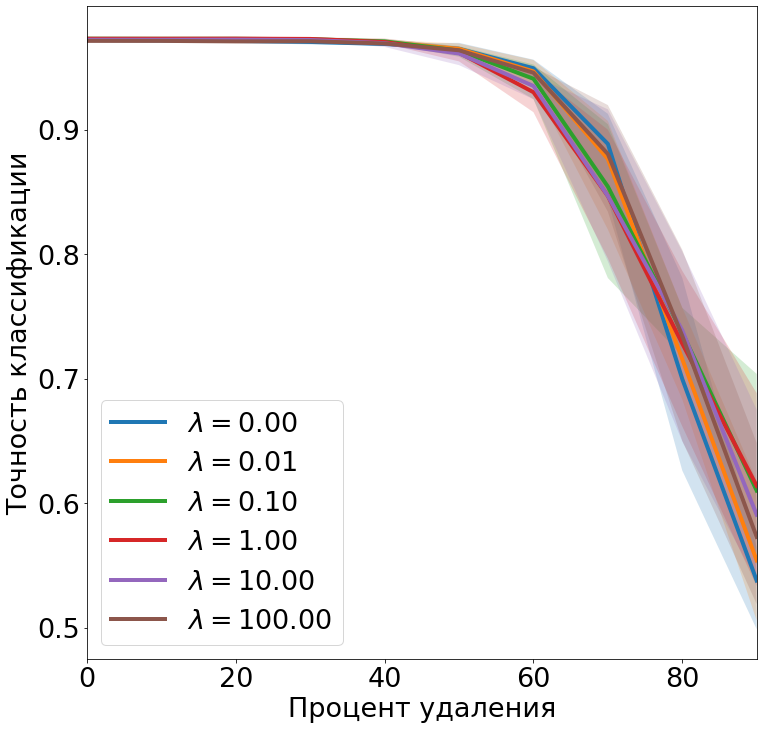

In [8]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Linear_rep')
#plt.show()
